In [1]:
"""
香草结构Vanilla的PDE定价基类
模型: BS + flat vol
定价方法: PDE
"""

import numpy as np
import scipy.sparse as sp
import scipy.interpolate as spi
import scipy.linalg as sla

TYPE_TO_SIGN = {'call': 1, 'put': -1}


class VanillaPDE():
    def __init__(self, r, q, vol, T, s0=100, strike=105, type="call"):  # method : "exp"/"imp"/"CN"
        self.s0 = s0  # 期初价格
        self.strike = strike  # 执行价
        self.T = T  # 到期时间(年)
        self.r = r  # 无风险利率
        self.q = q  # 分红/融券率
        self.vol = vol  # 波动率
        self.type = type  # 看涨看跌: call/put
        self.set_method_params()
        # print('成功创建一个香草期权的PDE定价实例')

    def set_method_params(self, params=None):
        """设置方法参数，选填，有默认值
        """
        if not isinstance(params, dict):
            return
        # 年化系数，默认值244日/年
        self.ndays = params['ndays'] if 'ndays' in params.keys() else 244
        # 时间步数，默认为年化系数 x 期权到期年数
        self.t_step = params['t_step'] if 't_step' in params.keys() else int(self.T * self.ndays)
        # 价格步数，默认为200
        self.s_step = params['s_step'] if 's_step' in params.keys() else 400
        # PDE定价参数：最小标的价格
        self.Smin = params['Smin'] if 'Smin' in params.keys() else 0
        # PDE定价参数：最大标的价格
        self.Smax = params['Smax'] if 'Smax' in params.keys() else self.s0 * 4
        # PDE定价数值方法：隐式/Crank-Nicolson
        self.method = params['method'] if 'method' in params.keys() else 'CN'

    def _load_params(self):
        self.sign = TYPE_TO_SIGN[self.type]
        self.dS = (self.Smax - self.Smin) / self.s_step
        self.dt = self.T / self.t_step
        self.S_vec = np.linspace(self.Smin, self.Smax, self.s_step + 1)
        self.T_vec = np.linspace(0, self.T, self.t_step + 1)
        self.i_vec = np.linspace(0, self.s_step, self.s_step + 1)
        self.grid = np.zeros(shape=(self.s_step + 1, self.t_step + 1))
        if self.method == 'CN':
            self.theta = 0.5
        elif self.method == 'imp':
            self.theta = 1
        elif self.method == "exp":
            if self.dt >= 1 / (self.vol * self.s_step) ** 2:
                print(f"Warning: dt >= 1/(vol * s_step)^2, 显式求解过程不稳定, 请增大t_step")
            self.theta = 0
        else:
            raise Exception(f"{self.method}不是exp(显式),imp(隐式)或CN(半隐式)方法, 请检查.")

    def _set_terminal_condition_(self):
        """终止条件"""
        self.grid[:, -1] = np.maximum(self.sign * (self.S_vec - self.strike), 0)

    def _set_boundary_condition_(self):
        """边界条件"""
        tau = self.T_vec[-1] - self.T_vec[:-1]
        if self.sign == 1:  # call
            self.grid[0, :] = 0
            self.grid[-1, :-1] = self.Smax * np.exp(-self.q * tau) - self.strike * \
                                 np.exp(-self.r * tau)
        else:  # put
            self.grid[0, :-1] = self.strike * np.exp(-self.r * self.tau)
            self.grid[-1, :] = 0

    def _solve_exp_(self):
        """显式求解"""
        # 递推系数：上一时间的相邻三项，经典PDE定义
        a = 0.5 * self.dt * (self.vol ** 2 * self.i_vec - (self.r - self.q)) * self.i_vec
        b = 1 - self.dt * (self.vol ** 2 * self.i_vec ** 2 + self.r)
        c = 0.5 * self.dt * (self.vol ** 2 * self.i_vec + (self.r - self.q)) * self.i_vec
        # 迭代递推，t_step为时间步数，从倒数第二天向第一天反向递推
        for j in reversed(np.arange(self.t_step)):
            # s_step为价格步数，计算除了最小Smin和最大Smax的其他所有的价格格点
            for i in range(1, self.s_step, 1):
                self.grid[i, j] = a[i] * self.grid[i - 1, j + 1] + b[i] * self.grid[i, j + 1] + c[i] * self.grid[
                    i + 1, j + 1]

    def _set_coefficient_(self):
        """系数矩阵预计算, l、d、u分别是对角线下方lower、主对角线diagonal和对角线上方upper的系数数组"""
        # self.i_vec[1:-1] == self.S_vec[1:-1] / self.dS
        drift = (self.r - self.q) * self.i_vec[1:-1]
        diffusion_square = (self.vol * self.i_vec[1:-1]) ** 2
        # 这里是以半隐式的系数写的，之后在_set_matrix_矩阵里整体乘以dt，再乘以theta=1/2。拆出theta是为了兼容隐式。
        self.l = 0.5 * (diffusion_square - drift)
        self.d = -diffusion_square - self.r
        self.u = 0.5 * (diffusion_square + drift)

    def _set_matrix_(self):
        """生成系数矩阵"""
        # 创建三对角矩阵A，用来构造半隐式矩阵M1，M2
        self.A = sp.diags([self.l[1:], self.d, self.u[:-1]], [-1, 0, 1], format='csc') * self.dt
        # 单位矩阵I
        self.I = sp.eye(self.s_step - 1)
        # j 时点的期权价值向量（未知量）的系数矩阵。
        self.M1 = self.I - self.theta * self.A
        # j + 1 时点的期权价值向量（已知量）的系数矩阵（对于隐式imp，M2是单位阵）
        self.M2 = self.I + (1 - self.theta) * self.A


    def _solve_imp_or_CN_(self):
        """隐式或半隐式求解: self.theta = 1 就是隐式方法, self.theta = 0.5 就是半隐式方法"""
        # 对系数矩阵M2做LU分解
        _, M_lower, M_upper = sla.lu(self.M1.toarray())
        # 将方程拆解为LUx=V, 先求解Ux，再求解x。x是j时点期权价值
        for j in reversed(np.arange(self.t_step)):
            # V = 矩阵方程右侧，系数M1乘以j + 1 时点的期权价值向量（已知量）
            V = self.M2.dot(self.grid[1:-1, j + 1])
            # 最上和最下两个方程额外多一项
            V[0] += self.theta * self.l[0] * self.dt * self.grid[0, j] \
                    + (1 - self.theta) * self.l[0] * self.dt * self.grid[0, j + 1]
            V[-1] += self.theta * self.u[-1] * self.dt * self.grid[-1, j] \
                     + (1 - self.theta) * self.u[-1] * self.dt * self.grid[-1, j + 1]
            # 将方程拆解为LUx=V, 先求解Ux
            Ux = sla.solve_triangular(M_lower, V, lower=True)
            # 再求解Ux=(L^-1)V中的x，x是j时点期权价值
            self.grid[1:-1, j] = sla.solve_triangular(M_upper, Ux, lower=False)

    def _interpolate_(self):
        tck = spi.splrep(self.S_vec, self.grid[:, 0], k=3)
        return spi.splev(self.s0, tck)

    def pricing(self):
        self._load_params()
        self._set_terminal_condition_()
        self._set_boundary_condition_()
        if self.method == "exp":
            self._solve_exp_()
        elif self.method in ["imp", "CN"]:
            self._set_coefficient_()
            self._set_matrix_()
            self._solve_imp_or_CN_()
        else:
            raise Exception(f"{self.method}不是exp(显式),imp(隐式)或CN(半隐式)方法, 请检查.")
        # print(f'香草结构的PDE-{self.method}定价')
        return self._interpolate_()


def adjust_method_params(model, method):
    # 定价方法参数
    if method == "exp":  # 显式为了求解稳定，t_step需要设的很大
        method_params = {'s_step': 200, 't_step': 5000, 'method': method}
    else:
        method_params = {'s_step': 400, 't_step': int(model.T * 244), 'method': method}
    # 设置方法参数
    model.set_method_params(method_params)
    return vanilla_pde


if __name__ == '__main__':
    method = "CN"  # "exp","imp","CN"
    # 定价模型实例
    vanilla_pde = VanillaPDE(r=0.02, q=0.0, vol=0.2, T=1, s0=100, strike=105, type='call')
    adjust_method_params(vanilla_pde, method)
    # 定价
    print(vanilla_pde.pricing())

6.702488021388638


In [2]:
import numpy as np
from scipy.stats import norm

class BSMmodel:         
    """欧式股票期权BSM公式"""
    def __init__(self, S, K, T, r, vol, sign=1, q=0):
        """认购期权的sign为1, 认沽期权的sign为-1。若股票有稳定的连续分红率q, 请传入参数q。
        """
        self.S, self.K, self.T, self.r, self.vol, self.sign, self.q = S, K, T, r, vol, sign, q

    def bsm_d(self):
        d1 = (np.log(self.S / self.K) + (self.r - self.q + 0.5 * self.vol ** 2) * self.T) / (
                self.vol * np.sqrt(self.T))
        d2 = d1 - self.vol * np.sqrt(self.T)
        return d1, d2

    @property
    def option_price(self):
        self.d1, self.d2 = self.bsm_d()
        return self.sign * np.exp(-self.q * self.T) * self.S * norm.cdf(self.sign * self.d1) - self.sign * np.exp(
            -self.r * self.T) * self.K * norm.cdf(self.sign * self.d2)
    
if __name__ == "__main__":
    vanilla_analytic = BSMmodel(S=100, K=105, T=1, r=0.02,vol=0.2, sign=1, q=0)
    print(vanilla_analytic.option_price)

6.704774819436658


In [3]:
price_arr = np.arange(80, 120, 5)
res = {"analytic":[], "exp":[], "imp":[], "CN":[]}

for price in price_arr:
    vanilla_analytic = BSMmodel(S=price, K=100, T=1, r=0.02,vol=0.2, q=0.01, sign=1)
    res["analytic"].append(vanilla_analytic.option_price)
    vanilla_pde = VanillaPDE(s0=price, strike=100, T=1, r=0.02, vol=0.2, q=0.01, type='call')
    adjust_method_params(vanilla_pde, "exp")
    res["exp"].append(vanilla_pde.pricing())
    adjust_method_params(vanilla_pde, "imp")
    res["imp"].append(vanilla_pde.pricing())
    adjust_method_params(vanilla_pde, "CN")
    res["CN"].append(vanilla_pde.pricing())

print("Done")

Done


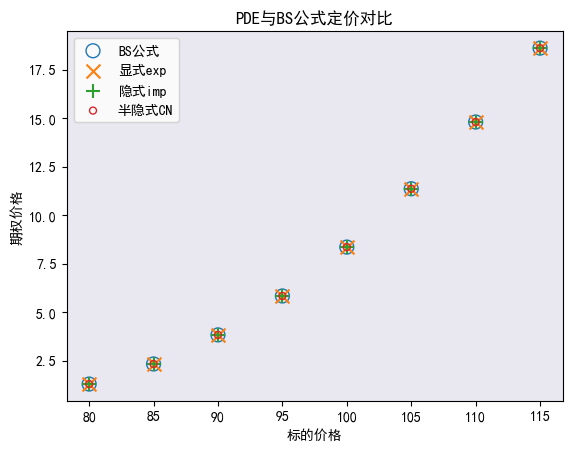

In [4]:
import matplotlib.pyplot as plt
plt.rcParams["font.sans-serif"] = ["SimHei"]  # 设置中文显示
plt.rcParams["axes.unicode_minus"] = False  # 解决负号显示为方块的问题
fig, ax = plt.subplots()
marker_size = 100
ax.scatter(price_arr, res["analytic"], edgecolors="#1f77b4", c='none', marker='o', s=marker_size, label="BS公式")
ax.scatter(price_arr, res["exp"], color="#ff7f0e", marker="x", s=marker_size, label="显式exp")
ax.scatter(price_arr, res["imp"], color="#2ca02c", marker="+", s=marker_size, label="隐式imp")
ax.scatter(price_arr, res["CN"], edgecolors="#d62728", c='none', marker=".", s=marker_size, label="半隐式CN")
ax.set_title('PDE与BS公式定价对比')
ax.set_xlabel('标的价格')
ax.set_ylabel('期权价格')
ax.set_facecolor('#e9e7ef')
ax.legend()
plt.show()
